<a href="https://colab.research.google.com/github/blackBagel/Sarcasm-Detection-Learn/blob/main/sarcasm_detection_simple_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ! pip install eli5

In [6]:
from __future__ import print_function
import pandas as pd
import numpy as np
import os
from google.colab import drive
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import spacy
import re
from sklearn import preprocessing, decomposition, model_selection, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
import eli5
import matplotlib.pyplot as plt
%matplotlib inline

# Data preparation

In [8]:
DRIVE_PATH = '/gdrive/My Drive/Reddit sarcasm'
drive.mount('/gdrive')
os.chdir(DRIVE_PATH)

In [17]:
DATA_COLUMNS = [
    'labels',
    'comments',
    'authors',
    'subreddit',
    'score',
    'ups',
    'downs',
    'date',
    'created_utc',
    'parent_comment'
]

full_comments_df = pd.read_csv("train-balanced-sarc.csv", delimiter='\t', names=DATA_COLUMNS)

## Methodology

First, let's see the data distributions

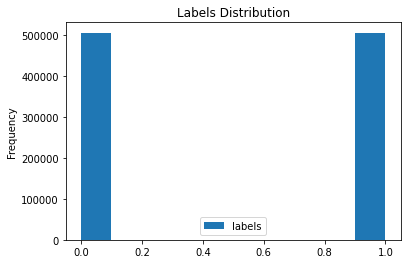

In [22]:
full_comments_df.plot(kind='hist', y='labels', title = 'Labels Distribution')

The data is balanced with regard to the labels. Therefore, I'll use the accuracy metric to evaluate all future models.

I prefer to evaluate all the models based primarily on accuracy. The data is well balanced and there is no actual buisiness problem i'm solving here, so there's not much of a need to specifically avoid either FPs or FNs.

I will however keep the precision and recall scores of all models for future reference

#### Train-Validation-Test Split 

The dataset is quite relatively large with about 1 million comments. For that reason, it is quite reasonable to use only 4% of the data as test and validation sets, since they'll still be 20k each.

That way, we'll have lots of data to train on.

In [24]:
comments_df_without_labels = full_comments_df.iloc[:, 1:]

# We use the same train-test split to test all of the next models
x_train, x_test, y_train, y_test = train_test_split(comments_df_without_labels,
                                                    full_comments_df['labels'],
                                                    random_state=1,
                                                    test_size=0.04,
                                                    shuffle=True)

x_val, x_test, y_val, y_test = train_test_split(x_test,
                                                y_test,
                                                random_state=1,
                                                test_size=0.5,
                                                shuffle=True)

Let's make sure the validation and test set have similar distributions

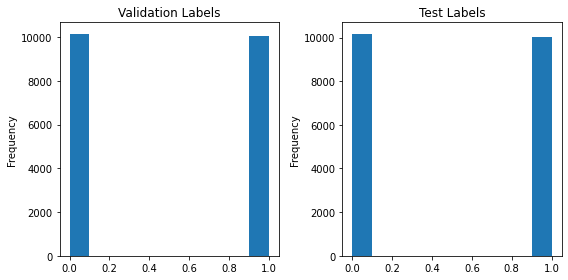

In [66]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4))

y_val.plot.hist(ax = axes[0], title='Validation Labels')
y_test.plot.hist(ax = axes[1], title='Test Labels')
fig.tight_layout()
plt.show()

# Research Process

## We begin our research by trying out a basic logistic regression model with different feature sets



### First, a relatively primitive count vectorizer of the texts

In [ ]:
ctv = CountVectorizer(ngram_range=(1, 2), min_df=2)
lr_ctv_clf = LogisticRegression(solver='saga', C=1, n_jobs=4, verbose=0)
ctv_logit_pipeline = Pipeline([('counter', ctv), 
                                 ('logitRegressor', lr_ctv_clf)])

In [ ]:
%%time
ctv_logit_pipeline.fit(x_train, y_train)

In [ ]:
predictions = ctv_logit_pipeline.predict_proba(x_test)
print ("logloss: %0.3f " % log_loss(y_test, predictions))
print ("accuracy: %0.3f " % ctv_logit_pipeline.score(x_test, y_test))

### We also test a basic tf-idf vector

In [ ]:
# We'll first try to create a simple baseline model
# Our baseline model will be a logistic regression model, which we'll train on the unigram tf_idf vectors of the original comments text 
tfv = TfidfVectorizer()

tfidf_logit_pipeline = Pipeline([('tf_idf', tfv), 
                                 ('logitRegressor', lr_tfv_clf)])
lr_tfv_clf = LogisticRegression(solver='saga')

In [ ]:
%%time
tfidf_logit_pipeline.fit(x_train, y_train)

In [ ]:
predictions = lr_tfv_clf.predict_proba(x_test)

print ("logloss: %0.3f " % log_loss(y_test, predictions))
print ("accuracy: %0.3f " % lr_tfv_clf.score(x_test, y_test))

### We try a more sophisticated tf-idf vector

In [ ]:
# Now let's try to run the same model, but on a more sophisticated tf-idf 
# This vectorizor is trained on both unigrams and bigrams, and only considers words that were used at least twice
tfv = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
lr_tfv_clf = LogisticRegression(solver='saga', C=1, n_jobs=4, verbose=0)
tfidf_logit_pipeline = Pipeline([('tf_idf', tfv), 
                                 ('logitRegressor', lr_tfv_clf)])

In [ ]:
%%time
tfidf_logit_pipeline.fit(x_train, y_train)

In [ ]:
# This model gave us the best performance for this part of the research
predictions = tfidf_logit_pipeline.predict_proba(x_test)
print ("logloss: %0.3f " % log_loss(y_test, predictions))
print ("accuracy: %0.3f " % tfidf_logit_pipeline.score(x_test, y_test))

In [ ]:
# Because it was te best model we tried to understand better what affected his performance
eli5.show_weights(estimator=tfidf_logit_pipeline.named_steps['logitRegressor'],
                  vec=tfidf_logit_pipeline.named_steps['tf_idf'])

### We theorize that certain pos tags could be strong indicators of sarcasm

In [ ]:
# !python -m spacy download en_core_web_lg
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner', 'textcat'])

In [ ]:
comments_pos_tags = []
print('Parsing pos tags...')
parsed_comments = [nlp(comment) for comment in tqdm(comments)]
for parsed_comment in parsed_comments:
  comment_pos_tags = []
  for word in parsed_comment:
    comment_pos_tags.append(word.tag_)
  comments_pos_tags.append(' '.join(comment_pos_tags))

In [ ]:
# Now let's try to run the same model, but on a more sophisticated tf-idf 
tfv = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
lr_tfv_clf = LogisticRegression(solver='saga', C=1, n_jobs=4, verbose=0)
tfidf_logit_pipeline = Pipeline([('tf_idf', tfv), 
                                 ('logitRegressor', lr_tfv_clf)])

# This vectorizor is trained on both unigrams and bigrams, and only considers words that were used at least twice
x_train, x_test, y_train, y_test = train_test_split(comments_pos_tags,
                                                    full_labels,
                                                    random_state=1,
                                                    test_size=0.2,
                                                    shuffle=True)

In [ ]:
%%time
tfidf_logit_pipeline.fit(x_train, y_train)

In [ ]:
predictions = tfidf_logit_pipeline.predict_proba(x_test)
print ("logloss: %0.3f " % log_loss(y_test, predictions))
print ("accuracy: %0.3f " % tfidf_logit_pipeline.score(x_test, y_test))

# As it seems, using the plain pos tags as replacements of the words, loses some vital information for the classification
eli5.show_weights(estimator=tfidf_logit_pipeline.named_steps['logitRegressor'],
                  vec=tfidf_logit_pipeline.named_steps['tf_idf'])